# Modeling the Probability Distribution

In [258]:
import math
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
from pprint import pprint
import matplotlib.pyplot as plt

In [186]:
@dataclass
class Marker:
    name: str
    median_mom_down: float
    median_mom_control: float
    log_sd_down: float = 0.0 # log of the sd of the marker in Down Syndrome cases
    log_sd_control: float = 0.0 # log of the sd of the marker in Control cases

In [189]:
@dataclass
class PopulationConfig:
    """
    Maternal Age is Normally distributed.
    """
    maternal_age_mean: float = 27.0 # Mean maternal age in years
    maternal_age_sd: float = 5.5 # SD of maternal age in years

    down_syndrome_prevalence: float = 1/700 # Prevalence of Down syndrome in the population

@dataclass
class MarkersConfig:
    """
    Config for the various markers being analysed
    """
    markers: list[Marker] = field(default_factory=list)
    
    correlation_matrix_down: np.ndarray = field(default_factory=lambda: np.eye(1)) # Correlatiuon matrix for Down syndrome cases
    correlation_matrix_control: np.ndarray = field(default_factory=lambda: np.eye(1)) # Correlation matrix for control cases

    def __post_init__(self):
        self.markers = [
            Marker(name="Free B-hCG", median_mom_down=1.70, median_mom_control=1.01, log_sd_down=0.28, log_sd_control=0.27),
            Marker(name="PAPP-A", median_mom_down=0.49, median_mom_control=1.00, log_sd_down=0.31, log_sd_control=0.25),
            Marker(name="NT", median_mom_down=1.74, median_mom_control=1.01, log_sd_down=0.23, log_sd_control=0.13),
        ]

        markers_count = len(self.markers)
        self.correlation_matrix_down = self.correlation_matrix_control = np.eye(markers_count)

In [219]:
pop_config = PopulationConfig(
    maternal_age_mean = 27.0,
    maternal_age_sd = 5.5
)

marker_config = MarkersConfig()

pprint(pop_config)
pprint(marker_config)

PopulationConfig(maternal_age_mean=27.0,
                 maternal_age_sd=5.5,
                 down_syndrome_prevalence=0.0014285714285714286)
MarkersConfig(markers=[Marker(name='Free B-hCG',
                              median_mom_down=1.7,
                              median_mom_control=1.01,
                              log_sd_down=0.28,
                              log_sd_control=0.27),
                       Marker(name='PAPP-A',
                              median_mom_down=0.49,
                              median_mom_control=1.0,
                              log_sd_down=0.31,
                              log_sd_control=0.25),
                       Marker(name='NT',
                              median_mom_down=1.74,
                              median_mom_control=1.01,
                              log_sd_down=0.23,
                              log_sd_control=0.13)],
              correlation_matrix_down=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [220]:
config.correlation_matrix_control

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [221]:
sample_size: int = 100_000

is_down = np.random.random(sample_size) < pop_config.down_syndrome_prevalence

sampled_prevalence = (np.sum(is_down) / sample_size)
print(sampled_prevalence)

assert np.allclose(sampled_prevalence, pop_config.down_syndrome_prevalence, atol=1/2000), "Sampled prevalence should be similar to expected prevalence"

0.00153


In [222]:
min_max = lambda v, tol: ((v - tol) * 100, (v + tol) * 100)

min_max(0.0014, 1/2000)

(0.09, 0.19)

Let X be a random variable with a log normal distribution  $N(\mu_X, \sigma^2_X$). Then the $ln(X)$ has the mean $\mu$ and variance $\sigma^2$.

$$
\begin{align}
\mu &= ln({\frac{\mu^2_X}{\sqrt{\mu^2_X + \sigma^2_X}}}) \\
\sigma^2 &= ln(1 + \frac{\sigma^2_X}{\mu^2_X})
\end{align}
$$

In [255]:
mu = np.log(pop_config.maternal_age_mean**2 / (np.sqrt(pop_config.maternal_age_mean**2 + pop_config.maternal_age_sd**2)))
sig2 = np.log(1 + (pop_config.maternal_age_sd ** 2 / pop_config.maternal_age_mean ** 2))

log_maternal_ages = np.random.normal(
    mu,
    np.sqrt(sig2),
    sample_size
)

print(
    mu, sig2
)

log_maternal_ages

3.275508180045729 0.04065737191719992


array([3.04965345, 3.33750811, 3.60236882, ..., 3.1938281 , 3.41287571,
       3.11328614])

In [256]:
def summary_stats(data: np.ndarray):
    print(f"X ~ N(μ, σ^2): N({np.mean(data):.4f}, {np.std(data)**2:.4f})")
    print(f"Range: {np.min(data):.4f} ≤ X ≤ {np.max(data):.4f}")

    print(f"median (M): {np.median(data):.4f}\n")

(array([3.000e+00, 2.200e+01, 8.500e+01, 2.910e+02, 6.390e+02, 1.375e+03,
        2.307e+03, 3.491e+03, 4.905e+03, 6.178e+03, 7.238e+03, 8.041e+03,
        8.460e+03, 8.467e+03, 8.028e+03, 7.347e+03, 6.404e+03, 5.705e+03,
        4.614e+03, 3.849e+03, 2.990e+03, 2.413e+03, 1.800e+03, 1.451e+03,
        1.108e+03, 7.660e+02, 5.460e+02, 4.460e+02, 3.160e+02, 2.170e+02,
        1.620e+02, 1.080e+02, 7.500e+01, 5.200e+01, 2.600e+01, 2.300e+01,
        1.800e+01, 1.200e+01, 8.000e+00, 5.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([11.10302253, 12.21397758, 13.32493263, 14.43588768, 15.54684273,
        16.65779778, 17.76875283, 18.87970788, 19.99066292, 21.10161797,
        22.21257302, 23.32352807, 24.43448312, 25.54543817, 26.65639322,
        27.76734827, 28.87830332, 29.98925837, 31.10021342, 32.21116847,
        33.32212352, 34.43307857, 35.54403362, 36.65498866, 37.76594371,
        38.

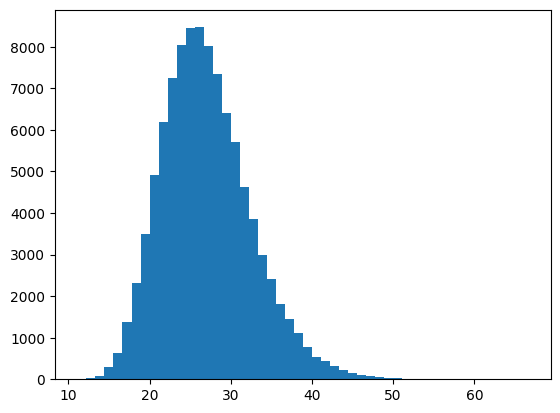

In [317]:
maternal_age = np.exp(log_maternal_ages)
plt.hist(maternal_age, bins=50)

In [318]:
summary_stats(log_maternal_ages)
summary_stats(np.exp(log_maternal_ages))

X ~ N(μ, σ^2): N(3.2755, 0.0406)
Range: 2.4072 ≤ X ≤ 4.1995
median (M): 3.2756

X ~ N(μ, σ^2): N(26.9990, 30.1752)
Range: 11.1030 ≤ X ≤ 66.6508
median (M): 26.4595



$$
Y = ln(X), Y \sim N(\mu, \sigma)
$$

$$
M = e^\mu
=> ln(M) = \mu
$$

In [319]:
mean_down = np.log([m.median_mom_down for m in marker_config.markers])
mean_control = np.log([m.median_mom_control for m in marker_config.markers])

mean_down, mean_control

(array([ 0.53062825, -0.71334989,  0.55388511]),
 array([0.00995033, 0.        , 0.00995033]))

## Covariance Matrices and Multivariate Distribution

In [320]:
cov_down = np.diag([m.log_sd_down**2 for m in marker_config.markers])
cov_control = np.diag([m.log_sd_control**2 for m in marker_config.markers])

cov_down, cov_control

(array([[0.0784, 0.    , 0.    ],
        [0.    , 0.0961, 0.    ],
        [0.    , 0.    , 0.0529]]),
 array([[0.0729, 0.    , 0.    ],
        [0.    , 0.0625, 0.    ],
        [0.    , 0.    , 0.0169]]))

In [321]:
correlation_matrix_down = np.array(
    [[1.0, 0.191, 0.0],
     [0.191, 1.0, 0.0],
     [0.0, 0.0, 1.0]]
)

In [322]:
correlation_matrix_control = np.array(
    [[1.0, 0.186, 0.0],
     [0.186, 1.0, 0.0],
     [0.0, 0.0, 1.0]]
)

In [323]:
cov_down = cov_down @ correlation_matrix_down @ cov_down
cov_down

array([[0.00614656, 0.00143904, 0.        ],
       [0.00143904, 0.00923521, 0.        ],
       [0.        , 0.        , 0.00279841]])

In [324]:
cov_control = cov_control @ correlation_matrix_control @ cov_control
cov_control

array([[0.00531441, 0.00084746, 0.        ],
       [0.00084746, 0.00390625, 0.        ],
       [0.        , 0.        , 0.00028561]])

In [325]:
log_marker_values_down = np.random.multivariate_normal(
    mean_down,
    cov_down,
    np.sum(is_down)
)

log_marker_values_down, log_marker_values_down.shape

(array([[ 0.64048082, -0.45763422,  0.52396608],
        [ 0.45052312, -0.59227148,  0.56558925],
        [ 0.56724229, -0.6689793 ,  0.47430877],
        [ 0.59763533, -0.73031411,  0.53167205],
        [ 0.47594115, -0.64262728,  0.64825042],
        [ 0.55081414, -0.80618359,  0.52405177],
        [ 0.37364069, -0.64840928,  0.58689585],
        [ 0.57282906, -0.84960203,  0.59841787],
        [ 0.55585133, -0.76989342,  0.56711451],
        [ 0.47807066, -0.78714041,  0.64902706],
        [ 0.71050277, -0.71789351,  0.63163356],
        [ 0.45403568, -0.84594293,  0.61223752],
        [ 0.56024985, -0.81699193,  0.50686075],
        [ 0.59017325, -0.8673571 ,  0.6223363 ],
        [ 0.46594459, -0.91876818,  0.59468102],
        [ 0.57533169, -0.62740756,  0.5925375 ],
        [ 0.48912359, -0.68386878,  0.53419938],
        [ 0.3723333 , -0.70958725,  0.63623503],
        [ 0.52674843, -0.75404724,  0.44015795],
        [ 0.55158439, -0.61888131,  0.60446323],
        [ 0.52387764

In [326]:
log_marker_values_control = np.random.multivariate_normal(
    mean_control,
    cov_control,
    np.sum(~is_down)
)

log_marker_values_control, log_marker_values_control.shape

(array([[ 0.01228474, -0.03512532, -0.01406786],
        [ 0.07783058, -0.02319073,  0.00148299],
        [-0.0180382 , -0.00813195,  0.03117401],
        ...,
        [ 0.06829399,  0.03078748,  0.0172539 ],
        [-0.0372469 ,  0.01955245, -0.00059807],
        [ 0.0379814 , -0.01990393, -0.00944319]]),
 (99847, 3))

In [327]:
log_marker_values = np.zeros((sample_size, len(marker_config.markers)))
log_marker_values.shape

(100000, 3)

In [328]:
log_marker_values[is_down] = log_marker_values_down
log_marker_values[~is_down] = log_marker_values_control

In [329]:
log_marker_values

array([[ 0.01228474, -0.03512532, -0.01406786],
       [ 0.07783058, -0.02319073,  0.00148299],
       [-0.0180382 , -0.00813195,  0.03117401],
       ...,
       [ 0.06829399,  0.03078748,  0.0172539 ],
       [-0.0372469 ,  0.01955245, -0.00059807],
       [ 0.0379814 , -0.01990393, -0.00944319]])

In [330]:
marker_values = np.exp(log_marker_values)
marker_values

array([[1.01236051, 0.96548441, 0.98603063],
       [1.08093951, 0.97707611, 1.00148409],
       [0.98212351, 0.99190103, 1.03166501],
       ...,
       [1.07068003, 1.03126631, 1.01740361],
       [0.96343823, 1.01974485, 0.99940211],
       [1.03871191, 0.98029285, 0.99060126]])

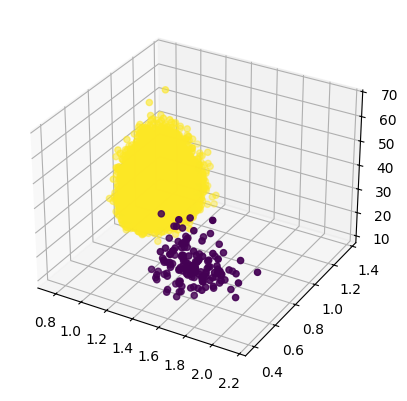

In [341]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    marker_values[:,0], 
    marker_values[:,1],  
    # marker_values[:,2],
    maternal_age,
    c=~is_down
)